## Sistema di Face Detection per una fotocamera digitale

- In questo progetto costruiremo un sistema di identificazione dei volti da zero, formato da una pipeline scikit-learn che prende un'immagine in ingresso e ritorna una lista con le coordinate dei bounding box. Per farlo addestreremo un nostro modello, con ridotte capacità di calcolo per permettere l'addestramento su macchina locale.

In [2]:
import os
import numpy as np
import random
import pickle
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from skimage.feature import hog
from skimage.transform import pyramid_gaussian, resize
from skimage import color
from skimage.io import imread
from sklearn.utils import shuffle
from tqdm import tqdm
from skimage.util import view_as_windows
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.color import rgb2gray
from joblib import dump, load

# Dataset

- Per il dataset facciale utilizzeremo il Flickr-Faces-HQ (FFHQ), che nella versione thumbnails offre circa 60000 immagini di volti in primissimo piano in formato 128x128. Nel nostro caso ne useremo 15000, per rendere il modello leggero e eseguibile in locale.

Link: "https://github.com/NVlabs/ffhq-dataset"

- Per il dataset non facciale utilizzeremo Cifar-10, composto da 10 classi ognuna con 10000 osservazioni.

Link: "https://www.cs.toronto.edu/~kriz/cifar.html"

In [3]:
# Percorsi dei dataset
face_path = r"C:\Users\deimo\Desktop\Data_Science\Master\Machine Learning - Tecniche avanzate\progetto\FACES"
non_face_path = r"C:\Users\deimo\Desktop\Data_Science\Master\Machine Learning - Tecniche avanzate\progetto\cifar-10-python\cifar-10-batches-py"

- Carichiamo il dataset facciale, impostando un numero massimo e una dimensione standard. Poi le memorizziamo in un array numpy.

In [4]:
def load_face_dataset(face_path, n=15000, target_size=(128, 128)):
    faces = [] # Lista vuota per memorizzare le immagini facciali
    
    # Controlla se il percorso è una directory
    if not os.path.isdir(face_path):
        raise ValueError(f"{face_path} non è una directory valida.")
    
    # Ottiene l'elenco dei file nella directory e filtra solo le immagini con estensioni valide
    image_names = [f for f in os.listdir(face_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(image_names)  # Mischia le immagini

    # Carica e processa ogni immagine
    for image_name in tqdm(image_names, desc="Loading face dataset"):
        image_path = os.path.join(face_path, image_name) # Costruisce il percorso completo dell'immagine
        try:
            face = imread(image_path) # legge l'immagine
            
            if face.ndim == 2:  # Se è in scala di grigi, convertilo in RGB
                face = np.stack([face] * 3, axis=-1)
            
            if face.shape[-1] == 3:  # Verifica che l'immagine sia a colori
                # Ridimensiona l'immagine a 128x128 se non lo è già
                if face.shape[:2] != target_size:
                    face = resize(face, target_size, anti_aliasing=True)
                faces.append(face)
                
                # Se il numero di immagini caricate raggiunge n, restituisci l'array numpy
                if len(faces) >= n:
                    return np.array(faces)
        except Exception as e:
            print(f"Errore nel caricamento dell'immagine {image_path}: {e}")
    
    return np.array(faces)

- Carichiamo il dataset non facciale.

In [5]:
# Funzione per caricare le immagini non faccia
def load_non_face_dataset(data_folder_path, n=15000):
    non_faces = []
    batch_files = [f for f in os.listdir(data_folder_path) if f.startswith('data_batch')]
    random.shuffle(batch_files)

    for batch_file in tqdm(batch_files, desc="Loading CIFAR-10 dataset"):
        batch_path = os.path.join(data_folder_path, batch_file)
        with open(batch_path, 'rb') as f:
            batch_data = pickle.load(f, encoding='bytes')
        images = batch_data[b'data']
        labels = batch_data[b'labels']

        for img, label in zip(images, labels):
            if label != 0:
                img = img.reshape(3, 32, 32).transpose(1, 2, 0)
                img = resize(img, (64, 64))
                non_faces.append(img)
                if len(non_faces) >= n:
                    return np.array(non_faces)
    return np.array(non_faces)


# Funzioni

- Questa funzione estrae le caratteristiche HOG (Histogram of Oriented Gradients) da un'immagine. Le caratteristiche HOG sono comunemente utilizzate nella computer vision per descrivere l'aspetto e la forma degli oggetti nelle immagini. Nello specifico l'HOG è un metodo che descrive la forma e l'orientamento degli oggetti in un'immagine utilizzando dei gradienti di intensità. Pertanto si può dire che catturi le informazioni dei contorni e le forme degli oggetti.

In [20]:
def extract_hog_features(image):
    # Controlla se l'immagine ha 3 canali (quindi se è a colori)
    if image.ndim == 3:
        # e la converte in scala di grigi.
        image = rgb2gray(image)
    return hog(image, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=False)



- Processamento dei dati che combina immagini facciali e non facciali, etichetta i dati, li mescola e poi li suddivide in set di addestramento e di test.

In [7]:
# Funzione per preparare i dati
def prepare_data(face_path, non_face_path):
    faces = load_face_dataset(face_path) 
    face_count = len(faces) # numero di immagini facciali
    # Carica il dataset delle immagini non facciali, assicurandoti che ci siano lo stesso numero di immagini come nel dataset facciale
    non_faces = load_non_face_dataset(non_face_path, n=face_count)
    # Ridimensiona tutte le immagini non facciali a 128x128x3 (RGB)
    non_faces = np.array([resize(img, (128, 128, 3)) for img in non_faces])

    # Controlla le dimensioni prima di concatenare
    print("Faces shape:", faces.shape)
    print("Non-faces shape:", non_faces.shape)
    
    X = np.vstack([faces, non_faces]) # Combina le immagini facciali e non facciali in un unico array
    y = np.hstack([np.ones(len(faces)), np.zeros(len(non_faces))])  # Crea le etichette per il dataset: 1 per le immagini facciali e 0 per le immagini non facciali
    X, y = shuffle(X, y, random_state=42) # Mescola i dati e le etichette in modo casuale
    return train_test_split(X, y, test_size=0.2, random_state=42) 

- Applichiamo la trasformazione HOG a un insieme di immagini.

In [8]:
# Funzione per applicare la trasformazione HOG
def apply_hog_transform(X):
    return np.array([extract_hog_features(image) for image in X])


- Addestriamo un modello di classificazione utilizzando una pipeline di preprocessing e un classificatore Support Vector Machine (SVM). La funzione utilizza il GridSearchCV per ottimizzare i parametri.

In [9]:
# Funzione per addestrare il modello
def train_model(X_train, y_train):
    hog_pipeline = Pipeline([ # Crea una pipeline con due passaggi: scaling e classificazione
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf',random_state=42, max_iter=15000))
    ])

    # Definisce una griglia di parametri per la ricerca su griglia
    param_grid = {
        'svm__C': [0.1, 1, 10], # valori per il parametro regolarizzazione C
        'svm__class_weight': [None, 'balanced']
    }
    grid_search = GridSearchCV(hog_pipeline, param_grid, cv=5, n_jobs=-1, verbose=1) # Configura la ricerca su griglia con cross-validation
    grid_search.fit(X_train, y_train) # Esegue la ricerca su griglia per trovare i migliori parametri
    print(f"Migliori parametri: {grid_search.best_params_}")
    print(f"Miglior punteggio: {grid_search.best_score_:.4f}")
    return grid_search.best_estimator_


- La non_max_suppression (NMS) è una tecnica utilizzata in vision computerizzata per ridurre i falsi positivi nella rilevazione degli oggetti, mantenendo solo le migliori bounding boxes (scatole di delimitazione) che non si sovrappongono troppo. Questa funzione è particolarmente utile in contesti come il rilevamento degli oggetti, dove possono essere generate molte bounding boxes per lo stesso oggetto.

In [10]:
def non_max_suppression(boxes, overlap_thresh=0.4):
    if len(boxes) == 0:
        return [] # Se non ci sono box, restituisce una lista vuota

    boxes = np.array(boxes) 
    pick = [] # Lista per tenere traccia delle box selezionate

    # Estrai le coordinate delle box
    x1 = boxes[:, 0] 
    y1 = boxes[:, 1] 
    x2 = boxes[:, 0] + boxes[:, 2] 
    y2 = boxes[:, 1] + boxes[:, 3] 
    area = (x2 - x1 + 1) * (y2 - y1 + 1) # Calcola l'area di ciascun box

    idxs = np.argsort(y2) # Ordina gli indici delle box in base alla coordinata y2

    while len(idxs) > 0:
        # Seleziona l'ultimo box (con il valore di y2 più grande)
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i) # Aggiungi questo box alla lista dei box selezionati
        suppress = [last] # Lista per tenere traccia degli indici dei box da sopprimere

        # Confronta il box corrente con gli altri box
        for pos in range(0, last):
            j = idxs[pos]
            # Trova le coordinate dell'intersezione tra due box
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
            w = max(0, xx2 - xx1 + 1) # Calcola la larghezza e l'altezza dell'intersezione
            h = max(0, yy2 - yy1 + 1)
            overlap = (w * h) / area[j] # Calcola l'area dell'intersezione

            if overlap > overlap_thresh: # Se la sovrapposizione è superiore alla soglia, segna il box per la soppressione
                suppress.append(pos)

        idxs = np.delete(idxs, suppress) # Rimuovi gli indici dei box soppressi

    return [boxes[i] for i in pick]  # Restituisce solo le box selezionate


In [11]:
def preprocess_image(image_path, target_size=(128, 128)):
    image = imread(image_path)

    # Verifica se l'immagine ha dimensioni diverse da quelle target
    if image.shape[:2] != target_size:
        # Ridimensiona l'immagine alle dimensioni target se necessario
        image = resize(image, target_size, anti_aliasing=True)
    return image


- La seguente funzione scansiona l'immagine a diverse scale, estrae le caratteristiche HOG dalle finestre dell'immagine e utilizza il modello per effettuare previsioni. Infine, applica la non max suppression per rimuovere i falsi positivi.

In [12]:
# Funzione per rilevare volti in un'immagine
def detect_faces(image, model, min_size=(128, 128), scale=1.5, step_size=4, confidence_threshold=0.5, overlap_thresh=0.3):
    face_boxes = []  # Lista per memorizzare le scatole di delimitazione dei volti rilevati
    scale_factor = 1  # Fattore di scala iniziale

    # Converti l'immagine in scala di grigi se è a colori
    if image.ndim == 3 and image.shape[-1] == 3:
        image = rgb2gray(image)

    # Scansiona l'immagine a diverse scale utilizzando la piramide gaussiana
    for resized in pyramid_gaussian(image, downscale=scale):
        # Se l'immagine ridimensionata è più piccola delle dimensioni minime, termina il ciclo
        if resized.shape[0] < min_size[0] or resized.shape[1] < min_size[1]:
            break

        # Scansiona l'immagine ridimensionata con finestre di dimensioni min_size
        for y in range(0, resized.shape[0] - min_size[0] + 1, step_size):
            for x in range(0, resized.shape[1] - min_size[1] + 1, step_size):
                # Estrai la finestra dell'immagine corrente
                window = resized[y:y + min_size[0], x:x + min_size[1]]
                # Estrai le caratteristiche HOG dalla finestra
                hog_features = extract_hog_features(window).flatten()

                # Verifica se il numero di caratteristiche HOG corrisponde al numero di caratteristiche richieste dal modello
                if len(hog_features) != model.named_steps['scaler'].n_features_in_:
                    continue

                # Ottieni il punteggio di decisione dal modello
                prediction = model.decision_function([hog_features])

                # Se il punteggio di decisione è maggiore della soglia di confidenza, considera la finestra come un volto
                if prediction > confidence_threshold:
                    # Calcola il fattore di scala per convertire le coordinate alle dimensioni originali dell'immagine
                    scale_factor = image.shape[1] / resized.shape[1]
                    # Aggiungi la scatola di delimitazione alla lista dei volti rilevati
                    face_boxes.append((
                        int(x * scale_factor),
                        int(y * scale_factor),
                        int(min_size[0] * scale_factor),
                        int(min_size[1] * scale_factor)
                    ))

        # Aggiorna il fattore di scala per la prossima iterazione
        scale_factor *= scale

    # Applica la soppressione non massima per rimuovere le scatole sovrapposte
    face_boxes = non_max_suppression(face_boxes, overlap_thresh=overlap_thresh)
    # Stampa i box rilevati per debug
    print(f"Detected face boxes: {face_boxes}")
    # Restituisce le scatole di delimitazione dei volti rilevati
    return face_boxes

- Visualizza i risultati del rilevamento di volti su un'immagine, evidenziando le aree in cui sono stati rilevati i volti.

In [13]:
# Funzione per visualizzare i risultati
def plot_detection_results(image, face_boxes):
    # Crea una figura e un asse per la visualizzazione
    fig, ax = plt.subplots(1, figsize=(12, 12 * image.shape[0] / image.shape[1]))
    
    # Disattiva gli assi per una visualizzazione più pulita
    ax.axis('off')
    
    # Mostra l'immagine sul grafico
    ax.imshow(image)  # Mostra l'immagine a colori se è a colori
    
    # Itera su tutte le scatole di delimitazione dei volti rilevati
    for (x, y, w, h) in face_boxes:
        # Crea un rettangolo per ogni faccia rilevata
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        # Aggiungi il rettangolo all'asse
        ax.add_patch(rect)
    
    # Ottimizza il layout della figura per evitare ritagli
    plt.tight_layout()
    
    # Mostra la figura con l'immagine e i rettangoli
    plt.show()



# Script principale

- Questo script esegue le seguenti operazioni: prepara i dati, applica la trasformazione HOG, addestra un modello di classificazione, salva il modello e valuta le prestazioni del modello sui dati di test.

In [14]:
if __name__ == "__main__":
    # Prepara i dati di addestramento e test
    X_train, X_test, y_train, y_test = prepare_data(face_path, non_face_path)

    # Applica la trasformazione HOG prima di addestrare il modello
    X_train_hog = apply_hog_transform(X_train)
    X_test_hog = apply_hog_transform(X_test)

    # Addestra il modello
    model = train_model(X_train_hog, y_train)

    # Salva il modello
    dump(model, 'face_detection_model.joblib')

    # Valuta il modello sui dati di test
    y_pred = model.predict(X_test_hog)
    print(classification_report(y_test, y_pred))

Loading CIFAR-10 dataset:  20%|██        | 1/5 [00:11<00:44, 11.11s/it]


Faces shape: (15000, 128, 128, 3)
Non-faces shape: (15000, 128, 128, 3)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Migliori parametri: {'svm__C': 10, 'svm__class_weight': None}
Miglior punteggio: 0.9993
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2957
         1.0       1.00      1.00      1.00      3043

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



In [15]:
    # Carica il modello (se necessario)
    # model = load('face_detection_model.joblib')

Detected face boxes: [array([ 56, 104, 128, 128])]


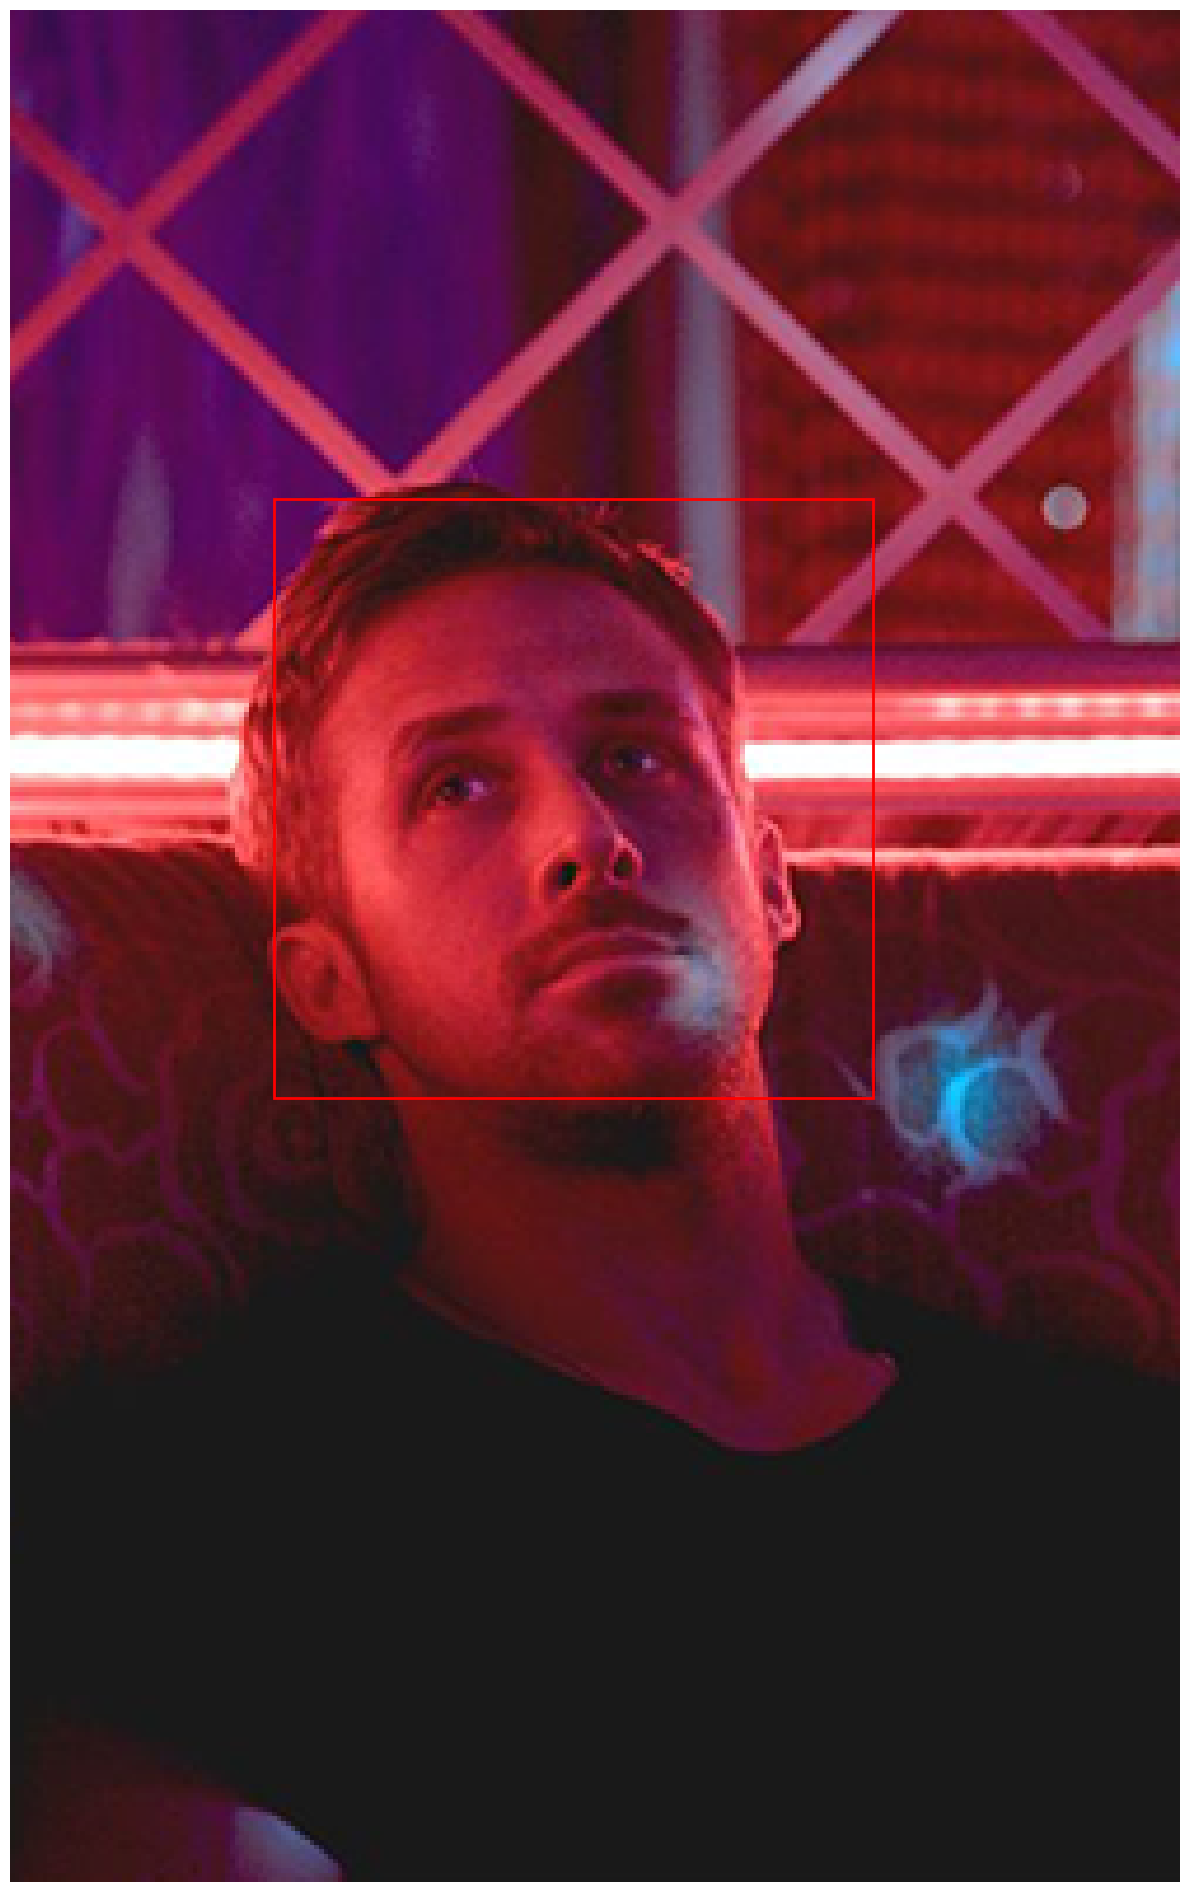

In [16]:
test_image_path = r"C:\Users\deimo\Desktop\Data_Science\Master\Machine Learning - Tecniche avanzate\progetto\prova2.png"
test_image = imread(test_image_path)
face_boxes = detect_faces(test_image, model, confidence_threshold=0.5, overlap_thresh=0.3)
plot_detection_results(test_image, face_boxes)

Detected face boxes: [array([120, 198, 192, 192]), array([642, 114, 192, 192]), array([468, 108, 192, 192])]


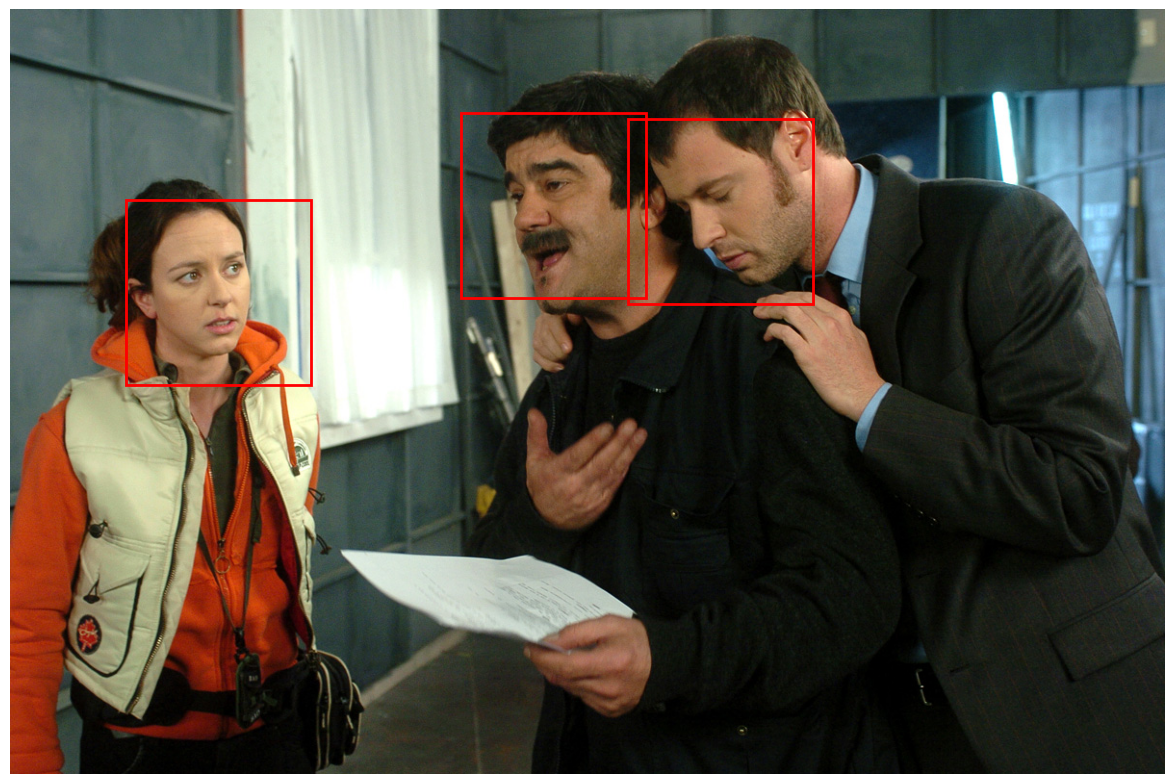

In [17]:
test_image_path = r"C:\Users\deimo\Desktop\Data_Science\Master\Machine Learning - Tecniche avanzate\progetto\boris.jpg"
test_image = imread(test_image_path)
face_boxes = detect_faces(test_image, model, confidence_threshold=0.7, overlap_thresh=0.2)
plot_detection_results(test_image, face_boxes)

Detected face boxes: [array([ 30, 151, 969, 969])]


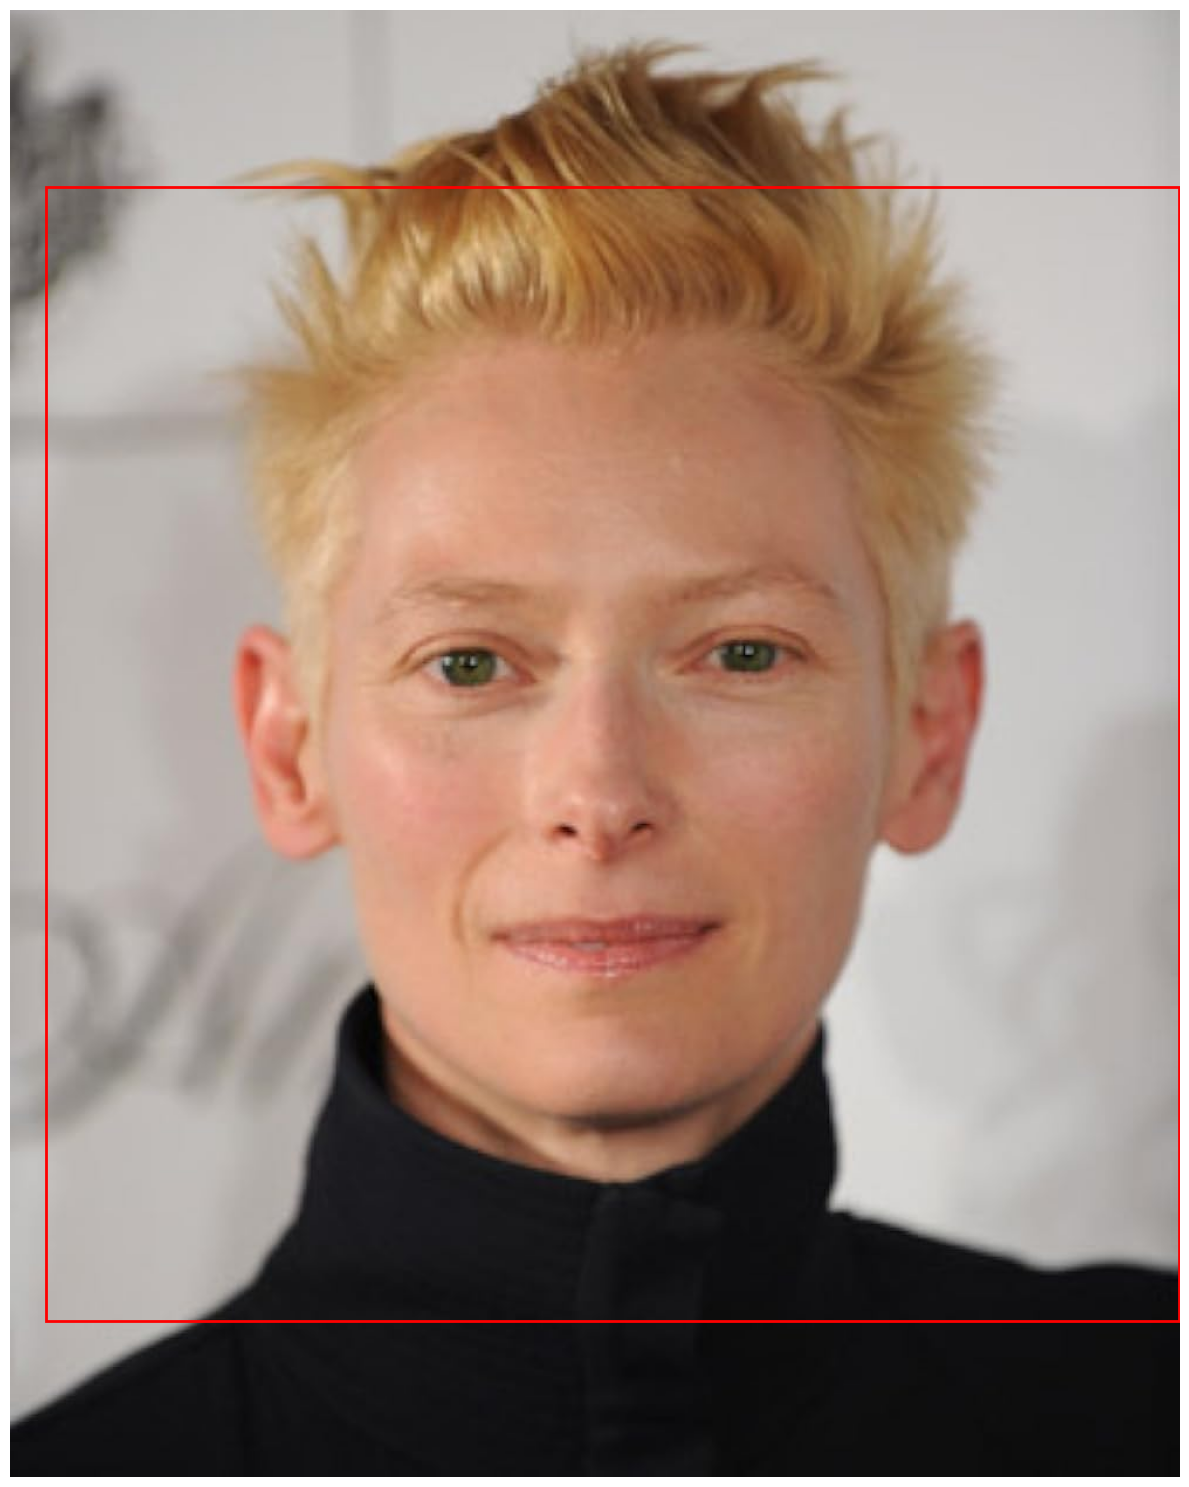

In [19]:
test_image_path = r"C:\Users\deimo\Desktop\Data_Science\Master\Machine Learning - Tecniche avanzate\progetto\prova.jpg"
test_image = imread(test_image_path)
face_boxes = detect_faces(test_image, model, confidence_threshold=0.5, overlap_thresh=0.3)
plot_detection_results(test_image, face_boxes)